# Strawberry Counting: From Baseline to Fine-Tuned YOLO

This notebook demonstrates a complete workflow for building an object counter, starting from a simple baseline model and progressing to a fine-tuned YOLOv11 model.

We will cover:
1.  **Dataset Preparation**: Splitting and formatting our strawberry image data.
2.  **Baseline Model**: Using OpenCV Template Matching for a quick and simple count.
3.  **Pre-trained YOLO**: Testing a generic, off-the-shelf YOLO model.
4.  **Fine-Tuning YOLO**: Training the YOLO model on our specific strawberry data.
5.  **Evaluation**: Comparing the results from the fine-tuned model.

In [1]:
import os
import sys
import cv2
import matplotlib.pyplot as plt

# Add src directory to path to import our custom modules
sys.path.append(os.path.abspath('src'))

# --- Configuration ---
# Define all the paths we will need
CWD = os.getcwd()
XML_PATH = os.path.join(CWD, 'dataset', 'annotations.xml')
IMAGES_DIR = os.path.join(CWD, 'dataset', 'images')
YOLO_DATASET_DIR = os.path.join(CWD, 'strawberry_dataset')
TEMPLATE_PATH = os.path.join(CWD, 'template', 'template.png')
BASELINE_OUT = os.path.join(CWD, 'output', 'baseline_result.png')
PRETRAINED_MODEL = 'yolo11s.pt'
FINETUNED_OUT_DIR = os.path.join(CWD, 'output', 'finetuned_preds')
PRETRAINED_OUT_DIR = os.path.join(CWD, 'output', 'pretrained_preds')

# Ensure output directories exist
os.makedirs('output', exist_ok=True)
os.makedirs('template', exist_ok=True)

## 1. Data Preparation

First, we need to prepare our dataset. The source data is a collection of images with a single XML file containing all annotations. We will split this into training and validation sets and convert the annotations to the YOLO `.txt` format that the model requires.

Our `split_and_prepare` function in `src/yolo_utils.py` handles this entire process.

In [2]:
from yolo_utils import split_and_prepare

print("Splitting data and creating YOLO-formatted dataset...")
split_and_prepare(XML_PATH, IMAGES_DIR, YOLO_DATASET_DIR)
print(f"Dataset successfully created at: {YOLO_DATASET_DIR}")

Splitting data and creating YOLO-formatted dataset...
Dataset successfully created at: c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset


## 2. Baseline Model: OpenCV Template Matching

Before diving into deep learning, we'll establish a baseline using a simple computer vision technique: template matching. This method works by sliding a "template" image (a small, cropped-out image of a strawberry) across a larger image to find matches.

It's fast but often struggles with variations in scale, rotation, and lighting.

2025-07-02 00:01:23,643 - INFO - Template saved to c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\template\template.png


Creating template from image 0...


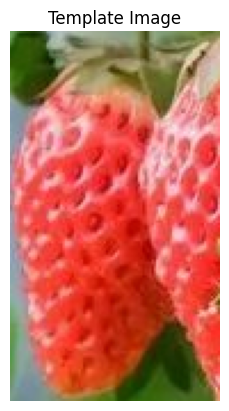

In [3]:
from baseline import create_template, run_baseline

# First, create a template from our dataset
print("Creating template from image 0...")
create_template(XML_PATH, IMAGES_DIR, TEMPLATE_PATH)

# Display the template
template_img = cv2.imread(TEMPLATE_PATH)
plt.imshow(cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB))
plt.title("Template Image")
plt.axis('off')
plt.show()

Running baseline detection on c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\dataset\images\1.png...


2025-07-02 00:01:23,861 - INFO - Baseline detection complete - 0 items found.


Baseline detected 0 strawberries.


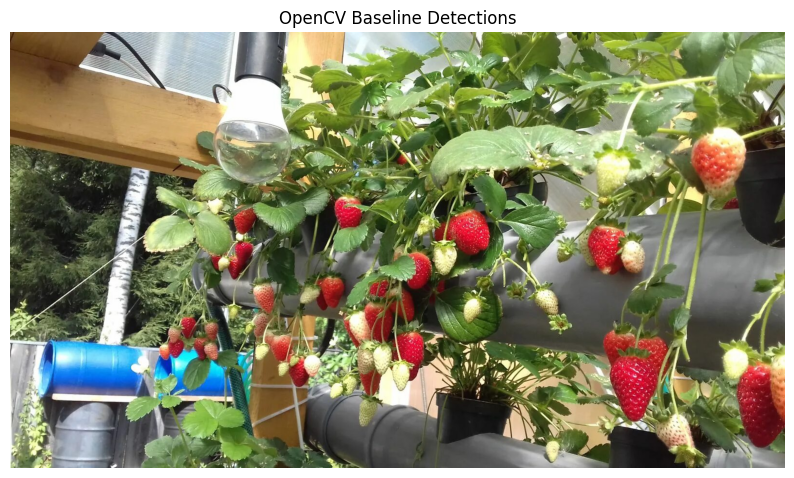

In [4]:
# Run the baseline model on a sample image
sample_image_path = os.path.join(IMAGES_DIR, '1.png')
print(f"Running baseline detection on {sample_image_path}...")
baseline_count = run_baseline(sample_image_path, TEMPLATE_PATH, BASELINE_OUT)
print(f"Baseline detected {baseline_count} strawberries.")

# Display the result
baseline_result = cv2.imread(BASELINE_OUT)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(baseline_result, cv2.COLOR_BGR2RGB))
plt.title("OpenCV Baseline Detections")
plt.axis('off')
plt.show()

## 3. Pre-trained YOLOv11 Inference

Now, let's see how a powerful, pre-trained YOLOv11 model performs without any specific training on our strawberries. This model has been trained on the large COCO dataset and can recognize 80 common object classes, but "strawberry" is not one of them. We are testing its ability to generalize.

In [5]:
from train_and_infer import run_inference
from ultralytics import YOLO

# Run inference on a single validation image to match displayed output
sample_img = os.path.join(YOLO_DATASET_DIR, 'images', 'val', '13.png')
print(f"Running pre-trained YOLOv11 inference on sample image {sample_img}...")
pretrained_sample_count = run_inference(PRETRAINED_MODEL, sample_img, PRETRAINED_OUT_DIR, conf=0.1)
print(f"Pre-trained model detected {pretrained_sample_count} strawberries in the sample image.")

# Display the sample result
pretrained_result_path = os.path.join(PRETRAINED_OUT_DIR, 'predictions', '13.png')
if os.path.exists(pretrained_result_path):
    pretrained_result = cv2.imread(pretrained_result_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(pretrained_result, cv2.COLOR_BGR2RGB))
    plt.title("Pre-trained YOLOv11 Detections (Sample)")
    plt.axis('off')
    plt.show()
else:
    print(f"Could not find result file at {pretrained_result_path}.")

Running pre-trained YOLOv11 inference on sample image c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset\images\val\13.png...


100%|██████████| 18.4M/18.4M [00:05<00:00, 3.83MB/s]



image 1/1 c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset\images\val\13.png: 512x640 2 apples, 1 potted plant, 65.7ms
Speed: 2.5ms preprocess, 65.7ms inference, 138.6ms postprocess per image at shape (1, 3, 512, 640)
Results saved to c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\output\pretrained_preds\predictions


2025-07-02 00:01:38,567 - INFO - Inference complete. Found 0 strawberry detections.


Pre-trained model detected 0 strawberries in the sample image.
Could not find result file at c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\output\pretrained_preds\predictions\13.png.


## 4. Fine-Tuning the YOLOv11 Model

The pre-trained model likely performed poorly because it hasn't been taught to recognize our specific strawberries. Now, we will fine-tune it. We take the pre-trained model and train it further on our labeled strawberry dataset. This teaches the model to become an expert at finding ripe strawberries.

**Note**: Training can take a significant amount of time, depending on your hardware (a GPU is highly recommended). We'll run it for just 25 epochs here as a demonstration. For best results, 100+ epochs are recommended.

## Enabling CUDA Support

To run training on GPU with CUDA, follow these steps:

1. Verify you have an NVIDIA GPU and the correct drivers installed:
   - Open the NVIDIA Control Panel or run `nvidia-smi` in PowerShell.
2. Install the CUDA Toolkit compatible with your GPU (e.g., CUDA 11.x):
   - Download from https://developer.nvidia.com/cuda-toolkit and follow the installer instructions.
3. Install PyTorch with CUDA support in your virtual environment:
   - Using pip:
     ```powershell
     pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
     ```
   - Or using conda:
     ```powershell
     conda install pytorch torchvision torchaudio cudatoolkit=11.7 -c pytorch
     ```
4. Restart your environment and confirm in Python:
   ```python
   import torch
   print(torch.cuda.is_available(), torch.cuda.device_count())
   ```

After completing these steps, rerun the training cell; it should detect and use your GPU.


In [6]:
import torch
print(torch.cuda.is_available(), torch.cuda.device_count())

True 1


## Troubleshooting GPU NMS Errors

If you see a `NotImplementedError` related to `torchvision::nms` on the CUDA backend, it means your `torchvision` build does not support GPU NMS. To fix this:

1. Uninstall any CPU-only versions:
   ```powershell
   pip uninstall -y torch torchvision
   ```
2. Reinstall PyTorch and torchvision with CUDA support (example for CUDA 11.7):
   ```powershell
   pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
   ```
3. Restart your environment.
4. Rerun the diagnostic cell below to confirm NMS on GPU.


In [7]:
from train_and_infer import train_model
import torch

data_yaml_path = os.path.join(YOLO_DATASET_DIR, 'data.yaml')

# Dynamically choose device: GPU if available, else CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print("Starting YOLOv11 model training...")
# For demonstration, we use a smaller number of epochs.
# We increase the epochs here for better results.
weights_path = train_model(data_yaml_path, epochs=300, device=device)
print(f"Training complete. Best weights saved at: {weights_path}")

Using device: cuda
Starting YOLOv11 model training...
New https://pypi.org/project/ultralytics/8.3.161 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.158  Python-3.12.9 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup

100%|██████████| 5.35M/5.35M [00:03<00:00, 1.65MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 107.147.9 MB/s, size: 772.2 KB)


train: Scanning C:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset\labels\train... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<00:00, 759.37it/s]

train: New cache created: C:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset\labels\train.cache


val: Fast image access  (ping: 0.00.0 ms, read: 103.757.7 MB/s, size: 1166.6 KB)


val: Scanning C:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset\labels\val... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 669.05it/s]

val: New cache created: C:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset\labels\val.cache


Plotting labels to output\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to output\train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300         4G      2.002      3.008      1.846        292        640: 100%|██████████| 2/2 [00:08<00:00,  4.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all          8         79      0.213      0.215      0.148     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      4.12G       2.06      2.792      1.886        421        640: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all          8         79      0.221      0.215      0.132     0.0521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      4.01G      1.949       3.03      1.915        234        640: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all          8         79      0.202      0.235      0.127     0.0455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      4.12G      1.887      2.584      1.861        335        640: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all          8         79      0.334      0.494      0.355      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      4.07G      1.591      1.765      1.571        320        640: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all          8         79       0.71      0.646       0.69      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      4.08G      1.463      1.392      1.394        436        640: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all          8         79      0.514      0.772      0.693      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      4.04G      1.464      1.365       1.43        328        640: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all          8         79      0.714      0.608      0.661      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      3.99G       1.37      1.277      1.305        287        640: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all          8         79      0.686      0.734      0.755      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      4.13G      1.345      1.239      1.278        247        640: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all          8         79      0.675      0.772      0.751      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      4.11G      1.375      1.295      1.259        263        640: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all          8         79      0.784      0.722      0.788      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300       4.1G      1.359      1.107      1.222        278        640: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all          8         79      0.883      0.671      0.781      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      4.14G      1.276        1.1      1.194        441        640: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all          8         79      0.784       0.62      0.738       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      4.17G      1.227      1.011      1.152        391        640: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all          8         79      0.746      0.632      0.753      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      4.14G      1.247      1.041       1.18        268        640: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all          8         79      0.774      0.772      0.779      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      4.11G      1.264      1.067      1.148        286        640: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all          8         79      0.781      0.677      0.764      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      4.08G      1.155     0.9828       1.13        366        640: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all          8         79      0.698      0.674       0.75      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      4.02G      1.141     0.9459       1.15        268        640: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all          8         79       0.82      0.544      0.705      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      4.15G      1.306     0.9669      1.194        329        640: 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all          8         79      0.828      0.544      0.695      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      4.13G      1.102     0.8722      1.103        305        640: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all          8         79      0.865      0.648      0.777      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      4.23G      1.131     0.8267      1.097        433        640: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all          8         79      0.801      0.772      0.844       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      4.09G      1.093     0.8054      1.133        303        640: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all          8         79      0.828      0.785      0.855      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      4.12G      1.167     0.8268      1.116        397        640: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all          8         79      0.809      0.642      0.756      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      4.14G      1.154     0.8218      1.126        340        640: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all          8         79      0.755      0.633      0.728      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      4.09G      1.156     0.7986      1.101        296        640: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all          8         79      0.698      0.759      0.784      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      4.09G      1.227     0.8458      1.192        356        640: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all          8         79      0.807      0.687      0.772      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      4.11G      1.073     0.8113        1.1        338        640: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all          8         79      0.803      0.671      0.764      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      4.08G      1.066     0.7701      1.085        361        640: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all          8         79      0.766      0.684      0.785      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      3.96G     0.9749     0.7418      1.054        222        640: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all          8         79      0.766      0.684      0.785      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      4.16G      1.027      0.707      1.089        299        640: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all          8         79      0.743      0.696       0.79      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      4.04G      1.019     0.7036      1.082        247        640: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all          8         79      0.737      0.604      0.688      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      4.13G      1.056     0.7445      1.065        334        640: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all          8         79      0.737      0.604      0.688      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      4.05G      1.088      0.746      1.086        275        640: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all          8         79      0.707      0.658      0.738      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      4.14G      1.036     0.6927      1.071        297        640: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all          8         79      0.732      0.588      0.706      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      4.13G     0.9472     0.6485      1.035        365        640: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all          8         79      0.732      0.588      0.706      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      4.12G      0.964     0.6859      1.016        365        640: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all          8         79      0.572      0.797       0.73      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      4.13G     0.9719      0.787      1.056        279        640: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all          8         79      0.729       0.58      0.689      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      3.97G     0.9826     0.6867      1.049        230        640: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all          8         79      0.729       0.58      0.689      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      4.25G      1.005     0.7789      1.057        416        640: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all          8         79      0.645      0.557       0.63       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      4.29G     0.9828     0.8009      1.032        392        640: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all          8         79      0.783      0.456      0.621      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      4.12G     0.9515     0.6926      1.038        238        640: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all          8         79      0.783      0.456      0.621      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      4.16G      1.013     0.7242      1.016        343        640: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all          8         79      0.798      0.658      0.699      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      4.04G       1.02     0.7666      1.049        313        640: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all          8         79      0.738      0.633      0.666      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      4.14G     0.9327     0.7274      1.016        277        640: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all          8         79      0.738      0.633      0.666      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      4.07G     0.9043     0.7394      1.016        271        640: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all          8         79      0.789      0.582      0.678      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      4.03G     0.9435     0.7847      1.008        320        640: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all          8         79      0.789      0.582      0.678      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300         4G     0.9602     0.7989      1.034        311        640: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all          8         79      0.811      0.709       0.79      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      4.05G     0.9136     0.7156      1.024        253        640: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all          8         79      0.811      0.709       0.79      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      4.13G     0.9025     0.6866      1.018        267        640: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all          8         79       0.82      0.759       0.79      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      4.03G      1.105     0.7262      1.084        307        640: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all          8         79       0.82      0.759       0.79      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      4.16G       1.07     0.6663      1.034        340        640: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all          8         79      0.776      0.831       0.85      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      4.09G     0.9541     0.6671     0.9869        425        640: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all          8         79      0.776      0.831       0.85      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      4.07G      0.979     0.6798      1.042        373        640: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all          8         79      0.833      0.818      0.839      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      4.07G     0.9267     0.6338     0.9974        378        640: 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all          8         79      0.833      0.818      0.839      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      4.11G     0.9074      0.656      1.034        304        640: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all          8         79      0.881      0.752      0.831      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      4.14G      1.122     0.7087      1.053        331        640: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all          8         79      0.881      0.752      0.831      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      4.08G      1.172     0.7684      1.062        344        640: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all          8         79      0.772      0.774      0.847      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      4.12G     0.9037     0.7233      1.008        346        640: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


                   all          8         79      0.772      0.774      0.847      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      4.17G     0.9744     0.7498      1.005        366        640: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all          8         79      0.723      0.835      0.783      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      4.14G      1.014     0.6691      1.047        365        640: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]

                   all          8         79      0.723      0.835      0.783      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      4.09G      1.032     0.6563      1.047        324        640: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all          8         79      0.752      0.785      0.782      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      4.06G     0.9169     0.6148     0.9978        289        640: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]

                   all          8         79      0.752      0.785      0.782      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300       4.1G     0.9196     0.6158      1.018        341        640: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all          8         79      0.831      0.709      0.776      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      4.13G     0.9228     0.5792     0.9811        397        640: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all          8         79      0.831      0.709      0.776      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      4.06G     0.9804     0.6147     0.9834        360        640: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all          8         79      0.782      0.725      0.775      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300       4.1G     0.9132     0.6156      1.009        292        640: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all          8         79      0.782      0.725      0.775      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      4.17G     0.8886     0.5943     0.9815        315        640: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all          8         79      0.722      0.722       0.79      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      4.11G     0.8749      0.571     0.9734        363        640: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all          8         79      0.722      0.722       0.79      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      4.15G     0.8335     0.5778     0.9595        308        640: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all          8         79      0.731      0.797      0.801      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      4.07G       0.83     0.5629      0.968        369        640: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all          8         79      0.731      0.797      0.801      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      4.09G     0.8385      0.597     0.9588        272        640: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]

                   all          8         79      0.814      0.773      0.818      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300       4.1G     0.8036     0.5413      0.951        286        640: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


                   all          8         79      0.814      0.773      0.818      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      4.12G     0.8768      0.601     0.9781        263        640: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all          8         79      0.822      0.734      0.793      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      4.12G     0.7692     0.5457     0.9702        334        640: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all          8         79      0.822      0.734      0.793      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300       4.1G     0.8062     0.5646     0.9392        406        640: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all          8         79      0.861      0.734      0.836      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      4.07G     0.8143     0.5154     0.9442        331        640: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]

                   all          8         79      0.861      0.734      0.836      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      4.05G     0.8154     0.5123     0.9587        332        640: 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


                   all          8         79      0.861      0.734      0.843      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      4.13G     0.7825     0.5177     0.9384        301        640: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]

                   all          8         79      0.861      0.734      0.843      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300       4.1G     0.7876     0.5161     0.9368        345        640: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]

                   all          8         79      0.809      0.751      0.806      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300         4G     0.7773     0.4999     0.9225        322        640: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all          8         79      0.809      0.751      0.806      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      4.15G     0.7778     0.5308     0.9449        347        640: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]

                   all          8         79       0.82      0.734      0.805      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      4.07G     0.7588     0.5113     0.9178        343        640: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all          8         79       0.82      0.734      0.805      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      4.14G     0.7574     0.5154     0.9341        296        640: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all          8         79      0.747      0.722      0.784      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      4.08G     0.7954     0.4955     0.9493        324        640: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all          8         79      0.747      0.722      0.784      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300       4.2G     0.8505     0.5123     0.9419        356        640: 100%|██████████| 2/2 [00:03<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all          8         79      0.711      0.696      0.754       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      4.08G     0.7491     0.4979     0.9287        319        640: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all          8         79      0.711      0.696      0.754       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      4.12G     0.7463      0.506     0.9446        303        640: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


                   all          8         79      0.798      0.701      0.779      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      4.05G     0.8685     0.5273      0.955        345        640: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all          8         79      0.798      0.701      0.779      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      4.05G     0.8504     0.5076      0.969        291        640: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all          8         79      0.804      0.722      0.781      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      4.27G     0.7941     0.5342      0.975        323        640: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all          8         79      0.804      0.722      0.781      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300       4.1G     0.7734     0.5233     0.9622        347        640: 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all          8         79      0.721      0.797      0.811      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      4.12G     0.7455     0.4837     0.9288        382        640: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.81it/s]

                   all          8         79      0.721      0.797      0.811      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      4.21G     0.7501     0.4796     0.9138        407        640: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all          8         79      0.741      0.832      0.831      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      4.05G     0.6838     0.4648     0.9138        246        640: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]

                   all          8         79      0.741      0.832      0.831      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300       4.1G     0.6805     0.4499     0.8948        352        640: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all          8         79      0.842      0.772       0.85      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      4.09G     0.7341      0.469     0.9117        364        640: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]

                   all          8         79      0.842      0.772       0.85      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      4.05G     0.7365     0.4909     0.9285        309        640: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all          8         79      0.738      0.861      0.831      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      4.11G     0.7088     0.4762     0.9283        285        640: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all          8         79      0.738      0.861      0.831      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      4.25G     0.6997     0.4617     0.8957        492        640: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all          8         79      0.701      0.873      0.815      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300       4.3G     0.7286     0.4588     0.9018        361        640: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all          8         79      0.701      0.873      0.815      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      4.15G     0.7319     0.4704     0.9246        279        640: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all          8         79      0.743      0.772      0.788      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      4.04G     0.6943     0.4856     0.9191        243        640: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all          8         79      0.743      0.772      0.788      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      4.18G     0.6957     0.4604     0.8843        298        640: 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all          8         79      0.699      0.785      0.783      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      4.03G     0.7101     0.4635     0.9226        246        640: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all          8         79      0.699      0.785      0.783      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      4.04G     0.7507        0.5      0.941        229        640: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all          8         79      0.846      0.628      0.767      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      4.18G     0.6973     0.4682     0.8931        435        640: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all          8         79      0.846      0.628      0.767      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      4.17G     0.6875     0.4558     0.9106        285        640: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all          8         79      0.774      0.696      0.778      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      4.18G     0.6904      0.454     0.8981        415        640: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all          8         79      0.774      0.696      0.778      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      4.11G     0.7105      0.457     0.9306        329        640: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all          8         79      0.843      0.747      0.835      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      4.12G     0.6592     0.4345     0.9016        343        640: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all          8         79      0.843      0.747      0.835      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      4.13G     0.6837     0.4517     0.9001        336        640: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all          8         79      0.826      0.759       0.83      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      4.06G     0.6621     0.4325     0.8997        300        640: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all          8         79      0.826      0.759       0.83      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      4.09G     0.7212     0.4704     0.9027        335        640: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all          8         79       0.84      0.733      0.825      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      3.99G     0.6768     0.4476     0.9196        238        640: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all          8         79       0.84      0.733      0.825      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300       4.1G     0.6966     0.4499     0.9088        331        640: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all          8         79       0.92      0.727      0.853      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      4.08G     0.6453     0.4389     0.9014        383        640: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all          8         79       0.92      0.727      0.853      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      4.09G     0.6622     0.4411     0.9187        278        640: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all          8         79      0.887      0.722      0.825      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      4.05G     0.7322     0.4914      0.951        192        640: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all          8         79      0.887      0.722      0.825      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      4.09G     0.6807     0.4425     0.9242        319        640: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all          8         79      0.866      0.739      0.821      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      4.11G     0.6629     0.4548     0.9062        312        640: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all          8         79      0.866      0.739      0.821      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      4.03G     0.6504      0.456     0.8926        396        640: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all          8         79       0.84      0.732      0.807      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      4.02G     0.6927      0.449     0.9184        253        640: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all          8         79       0.84      0.732      0.807      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      4.09G     0.7103       0.44     0.9185        318        640: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all          8         79      0.868      0.671      0.816      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      4.04G      0.698     0.4492     0.8976        394        640: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all          8         79      0.868      0.671      0.816      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      4.13G     0.6779     0.4312     0.8778        319        640: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all          8         79      0.909      0.684      0.818      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      4.12G     0.6848     0.4384     0.8874        351        640: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]

                   all          8         79      0.909      0.684      0.818      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      4.19G     0.7338      0.455     0.9197        318        640: 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all          8         79      0.899      0.747      0.857      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300       4.2G     0.7344     0.4513     0.8997        307        640: 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all          8         79      0.899      0.747      0.857      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      4.15G      0.656     0.4246     0.9009        307        640: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all          8         79      0.897      0.734      0.856      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      4.12G     0.6159     0.4129     0.8875        344        640: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all          8         79      0.897      0.734      0.856      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300       4.1G     0.6711     0.4328     0.8946        358        640: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]

                   all          8         79      0.879      0.772      0.856      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      4.12G     0.7017     0.4403     0.8979        415        640: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all          8         79      0.879      0.772      0.856      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      4.06G      0.636     0.4224     0.8647        273        640: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all          8         79      0.898      0.777      0.849      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      4.12G     0.6366     0.4398       0.89        399        640: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all          8         79      0.898      0.777      0.849      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      4.27G     0.6517     0.4269     0.9163        390        640: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all          8         79      0.864      0.759      0.798      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      4.09G     0.6222     0.4122     0.8856        304        640: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]

                   all          8         79      0.864      0.759      0.798      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      4.12G     0.6184     0.4191     0.8881        330        640: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all          8         79       0.87      0.759      0.799      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      4.19G     0.6635     0.4245     0.8989        395        640: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all          8         79       0.87      0.759      0.799      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      4.19G     0.6456     0.4258     0.8827        426        640: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all          8         79      0.869      0.759      0.839      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      4.12G     0.6259     0.4195     0.8782        304        640: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all          8         79      0.869      0.759      0.839      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      4.12G     0.5862     0.3934     0.8802        287        640: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all          8         79      0.775      0.759       0.83      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      4.12G      0.628     0.4065     0.8833        359        640: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]

                   all          8         79      0.775      0.759       0.83      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      4.16G     0.6253     0.4062     0.9019        302        640: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all          8         79       0.91      0.643      0.815      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      4.06G     0.6562     0.4317     0.8963        390        640: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

                   all          8         79       0.91      0.643      0.815      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      4.09G     0.6409      0.411     0.8947        262        640: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]

                   all          8         79      0.909      0.658      0.812        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      4.04G     0.6181     0.4075     0.8746        263        640: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

                   all          8         79      0.909      0.658      0.812        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      4.22G     0.6329     0.4205      0.884        450        640: 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

                   all          8         79      0.897      0.709      0.846      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      4.08G     0.6491     0.4165     0.8645        360        640: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all          8         79      0.897      0.709      0.846      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      4.05G     0.6408     0.4022     0.9071        233        640: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all          8         79      0.934      0.709      0.854      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      4.07G     0.6009     0.3929     0.8567        301        640: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all          8         79      0.934      0.709      0.854      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      4.12G     0.5942     0.3965     0.8655        323        640: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]

                   all          8         79      0.919      0.723      0.832      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      4.05G     0.5609     0.3929      0.871        303        640: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all          8         79      0.919      0.723      0.832      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      4.13G     0.5982      0.396      0.889        293        640: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all          8         79      0.919      0.747      0.822      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300       4.1G     0.6282     0.3939     0.8769        327        640: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all          8         79      0.919      0.747      0.822      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300         4G      0.623     0.3995     0.8659        308        640: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]

                   all          8         79      0.929      0.747       0.82      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      4.12G     0.5867      0.394     0.8853        310        640: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all          8         79      0.929      0.747       0.82      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      4.09G     0.5388     0.3689     0.8615        321        640: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all          8         79      0.911      0.747      0.822      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      4.09G     0.5493     0.3768     0.8577        262        640: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]

                   all          8         79      0.911      0.747      0.822      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      4.11G      0.578     0.3818     0.8801        308        640: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all          8         79      0.866      0.759      0.823      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      4.04G     0.5505     0.3826     0.8871        269        640: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all          8         79      0.866      0.759      0.823      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      4.13G     0.6168     0.3921     0.8829        431        640: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all          8         79      0.891      0.734       0.81      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300       4.1G      0.545     0.3793      0.859        304        640: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]

                   all          8         79      0.891      0.734       0.81      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      4.09G     0.5539     0.3854      0.877        278        640: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all          8         79      0.932      0.722       0.84      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      4.08G     0.5608      0.379     0.8919        288        640: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all          8         79      0.932      0.722       0.84      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      4.05G     0.5728     0.3807     0.8623        343        640: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all          8         79      0.905      0.721      0.856      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      4.15G      0.559     0.3776     0.8633        312        640: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all          8         79      0.905      0.721      0.856      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      4.28G     0.5713     0.3861     0.8581        432        640: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all          8         79      0.774      0.785      0.853      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      4.17G     0.5543     0.3788     0.8572        346        640: 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]

                   all          8         79      0.774      0.785      0.853      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      4.18G     0.5868      0.383     0.8609        428        640: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all          8         79      0.879      0.671      0.849      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300       4.2G     0.5439     0.3802     0.8558        426        640: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]

                   all          8         79      0.879      0.671      0.849      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      4.11G     0.5225     0.3788     0.8576        380        640: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all          8         79      0.893      0.671      0.861      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      3.99G     0.5644     0.3824     0.8682        287        640: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]

                   all          8         79      0.893      0.671      0.861      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      4.08G     0.5425     0.3737     0.8527        354        640: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all          8         79      0.912      0.646      0.838      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300       4.1G     0.5601     0.3786     0.8717        244        640: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]

                   all          8         79      0.912      0.646      0.838      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      4.09G     0.5624     0.3651      0.851        354        640: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all          8         79      0.884      0.709      0.851      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      4.26G     0.5905     0.4147     0.8542        412        640: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all          8         79      0.884      0.709      0.851      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      4.06G     0.5517     0.3814     0.8424        364        640: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all          8         79      0.911      0.722      0.856      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      4.12G     0.6071     0.4083     0.8632        433        640: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


                   all          8         79      0.911      0.722      0.856      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      4.09G     0.5785     0.3809     0.8774        299        640: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all          8         79      0.943      0.709      0.865      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      4.08G     0.5152     0.3588     0.8583        284        640: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all          8         79      0.943      0.709      0.865      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      4.15G     0.5682     0.3748     0.8735        424        640: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all          8         79      0.965      0.706      0.864       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      4.12G     0.5223      0.365     0.8572        276        640: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]

                   all          8         79      0.965      0.706      0.864       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      4.12G     0.5386     0.3737     0.8714        283        640: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


                   all          8         79      0.934      0.722      0.878      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      4.13G      0.594      0.379     0.8512        273        640: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all          8         79      0.934      0.722      0.878      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      4.05G     0.5618     0.3735     0.8452        322        640: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all          8         79      0.882      0.772      0.887      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      4.09G     0.5451     0.3722     0.8562        359        640: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all          8         79      0.882      0.772      0.887      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      4.05G     0.5265     0.3652     0.8509        288        640: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]

                   all          8         79      0.947      0.734      0.885      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      4.13G     0.5198     0.3595     0.8532        347        640: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all          8         79      0.947      0.734      0.885      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      4.08G     0.4823     0.3345     0.8396        300        640: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all          8         79      0.858      0.785      0.885      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      4.07G     0.5114     0.3497     0.8539        304        640: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]

                   all          8         79      0.858      0.785      0.885      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      4.14G     0.5289     0.3543     0.8613        253        640: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all          8         79      0.921      0.741      0.875       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      4.12G     0.4955      0.349     0.8474        269        640: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all          8         79      0.921      0.741      0.875       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      3.99G     0.5026     0.3503     0.8442        267        640: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

                   all          8         79      0.933      0.747       0.87      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      4.14G     0.5081      0.357     0.8418        314        640: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all          8         79      0.933      0.747       0.87      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      4.09G     0.4928     0.3574     0.8646        273        640: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all          8         79      0.936      0.759       0.87      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      4.13G     0.4726     0.3374     0.8458        275        640: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all          8         79      0.936      0.759       0.87      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      4.11G     0.4844     0.3568      0.863        438        640: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all          8         79      0.936      0.745      0.867       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      4.35G     0.5093     0.3505     0.8433        453        640: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all          8         79      0.936      0.745      0.867       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300       4.1G     0.5049     0.3524     0.8562        316        640: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all          8         79       0.96      0.722      0.866      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      4.19G     0.5059     0.3434      0.845        377        640: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]

                   all          8         79       0.96      0.722      0.866      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      4.11G     0.4652     0.3391     0.8405        398        640: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all          8         79       0.91      0.767      0.871      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      4.17G     0.5041     0.3458     0.8552        369        640: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all          8         79       0.91      0.767      0.871      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300       4.1G     0.4796     0.3434      0.843        366        640: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all          8         79      0.896      0.766      0.871       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300       4.1G     0.4701     0.3322     0.8367        261        640: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all          8         79      0.896      0.766      0.871       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      4.12G     0.5075     0.3529     0.8318        446        640: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

                   all          8         79      0.825      0.823      0.877       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      4.05G     0.5117       0.35     0.8419        392        640: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all          8         79      0.825      0.823      0.877       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      4.12G     0.4979     0.3552     0.8561        246        640: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all          8         79      0.844      0.822      0.881      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      4.21G     0.4673     0.3331     0.8347        393        640: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all          8         79      0.844      0.822      0.881      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      4.11G     0.4741     0.3278      0.838        301        640: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all          8         79      0.862       0.81      0.883      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      4.18G     0.5284     0.3559     0.8512        314        640: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]

                   all          8         79      0.862       0.81      0.883      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      4.04G     0.5042     0.3497     0.8416        330        640: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all          8         79      0.923      0.759      0.881      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      4.29G     0.4808     0.3401     0.8391        439        640: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all          8         79      0.923      0.759      0.881      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      4.14G     0.5176     0.3558     0.8443        356        640: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]

                   all          8         79      0.875      0.797       0.88      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      4.13G     0.4905     0.3315     0.8511        303        640: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


                   all          8         79      0.875      0.797       0.88      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      4.15G     0.4913     0.3459     0.8564        318        640: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all          8         79      0.852      0.785      0.867       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      4.15G     0.4642     0.3346     0.8559        311        640: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all          8         79      0.852      0.785      0.867       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      4.14G       0.48      0.328     0.8354        385        640: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all          8         79      0.958      0.709      0.864      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      4.11G     0.4938     0.3369     0.8507        283        640: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all          8         79      0.958      0.709      0.864      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      4.15G     0.4954     0.3321     0.8425        357        640: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all          8         79      0.921      0.733      0.864      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      4.06G     0.5085     0.3334     0.8537        441        640: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]

                   all          8         79      0.921      0.733      0.864      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      4.11G     0.4786     0.3244     0.8409        369        640: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all          8         79      0.943      0.734       0.86       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      4.06G     0.4935     0.3417     0.8454        260        640: 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all          8         79      0.943      0.734       0.86       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      4.13G     0.4973     0.3365     0.8445        298        640: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all          8         79      0.933      0.734      0.855      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      4.08G     0.4728     0.3291     0.8521        320        640: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all          8         79      0.933      0.734      0.855      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      4.01G      0.504     0.3355     0.8554        272        640: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all          8         79      0.944      0.722      0.852      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      4.14G     0.4929     0.3443     0.8526        324        640: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all          8         79      0.944      0.722      0.852      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      4.08G     0.4526      0.316     0.8323        331        640: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all          8         79      0.933       0.71      0.847      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      4.08G     0.4849     0.3336     0.8599        316        640: 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all          8         79      0.933       0.71      0.847      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      4.01G     0.4706     0.3323     0.8689        276        640: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all          8         79      0.945      0.709      0.856      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      4.08G     0.4842     0.3523     0.8559        218        640: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all          8         79      0.945      0.709      0.856      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      4.07G     0.4519     0.3171     0.8493        291        640: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all          8         79      0.904      0.734      0.845      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      4.16G     0.4931     0.3351     0.8394        396        640: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all          8         79      0.904      0.734      0.845      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      4.06G     0.4521     0.3189     0.8293        247        640: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all          8         79      0.838      0.797      0.861      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      4.13G     0.4517     0.3252     0.8238        356        640: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all          8         79      0.838      0.797      0.861      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      4.14G     0.4539     0.3263     0.8368        394        640: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all          8         79      0.837      0.797      0.866      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      4.19G     0.4812     0.3341     0.8344        418        640: 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all          8         79      0.837      0.797      0.866      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300       4.1G     0.4582     0.3243     0.8524        407        640: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all          8         79      0.862      0.793      0.876      0.562
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 186, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



236 epochs completed in 0.250 hours.
Optimizer stripped from output\train\weights\last.pt, 19.2MB
Optimizer stripped from output\train\weights\best.pt, 19.2MB

Validating output\train\weights\best.pt...
Ultralytics 8.3.158  Python-3.12.9 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


                   all          8         79      0.946      0.734      0.885      0.582
Speed: 0.4ms preprocess, 5.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to output\train


2025-07-02 00:16:59,277 - INFO - Training complete. Best weights at: output\train\weights\best.pt


Training complete. Best weights saved at: output\train\weights\best.pt


### Visualizing Training Results

After training, the `ultralytics` library saves several useful plots in the `output/train/` directory. Let's look at the results graph, which shows how metrics like precision and recall improved over the training epochs, and the confusion matrix.

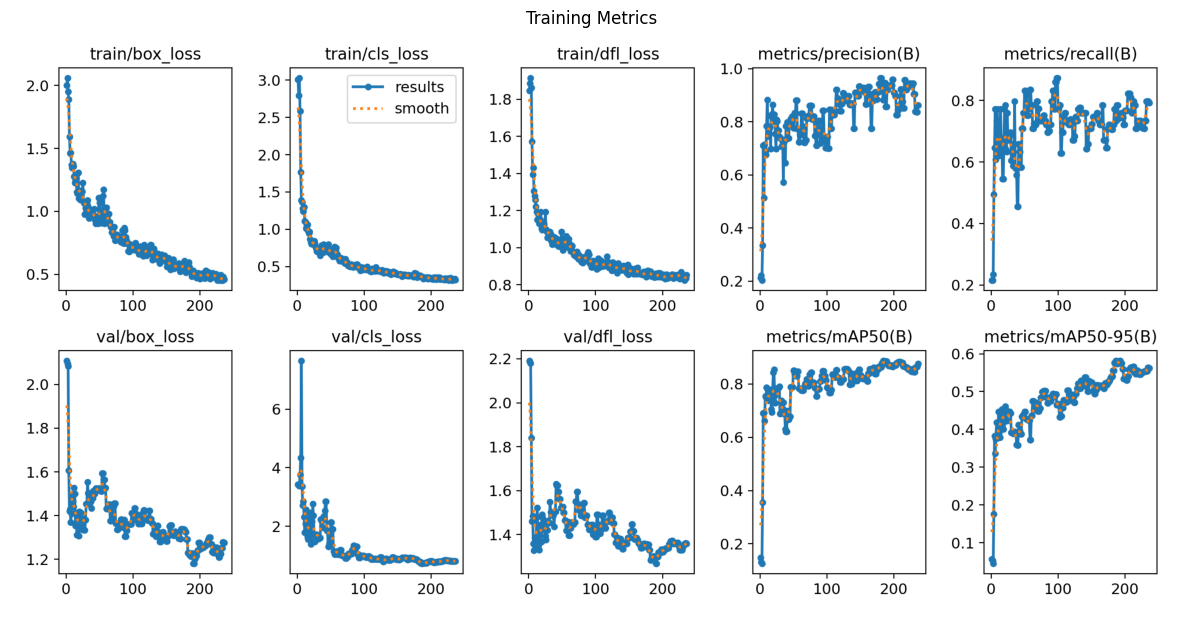

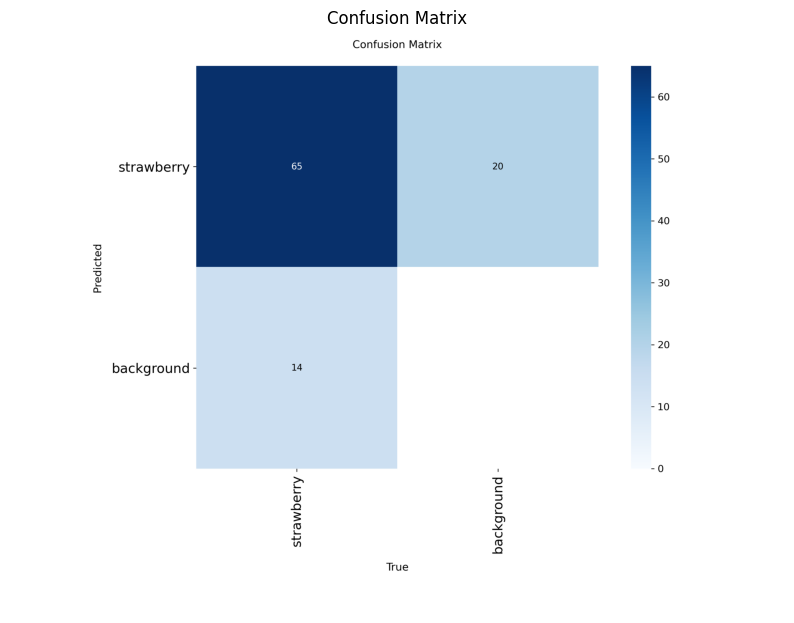

In [8]:
# Display the training results plot and confusion matrix
results_plot_path = os.path.join('output', 'train', 'results.png')
confusion_matrix_path = os.path.join('output', 'train', 'confusion_matrix.png')

if os.path.exists(results_plot_path):
    results_img = cv2.imread(results_plot_path)
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(results_img, cv2.COLOR_BGR2RGB))
    plt.title("Training Metrics")
    plt.axis('off')
    plt.show()
else:
    print(f"Could not find training results plot at {results_plot_path}")

if os.path.exists(confusion_matrix_path):
    cm_img = cv2.imread(confusion_matrix_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB))
    plt.title("Confusion Matrix")
    plt.axis('off')
    plt.show()
else:
    print(f"Could not find confusion matrix at {confusion_matrix_path}")

## 5. Inference with the Fine-Tuned Model

With our newly fine-tuned model, let's run inference on the same validation images and see the difference. We expect a significant improvement in detection accuracy.

### Note on Directory Inference
This cell runs inference on the entire validation directory (8 images). Each image in the `val` folder is processed, which is why you see outputs for all of them. If you only want to view detections on a single image, use the sample inference cell above instead.

Running fine-tuned YOLOv11 inference on sample image c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset\images\val\13.png...

image 1/1 c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset\images\val\13.png: 512x640 10 strawberrys, 65.8ms
Speed: 5.0ms preprocess, 65.8ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)
Results saved to c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\output\finetuned_preds\predictions


2025-07-02 00:17:00,736 - INFO - Inference complete. Found 10 strawberry detections.


Fine-tuned model detected 10 strawberries in the sample image.


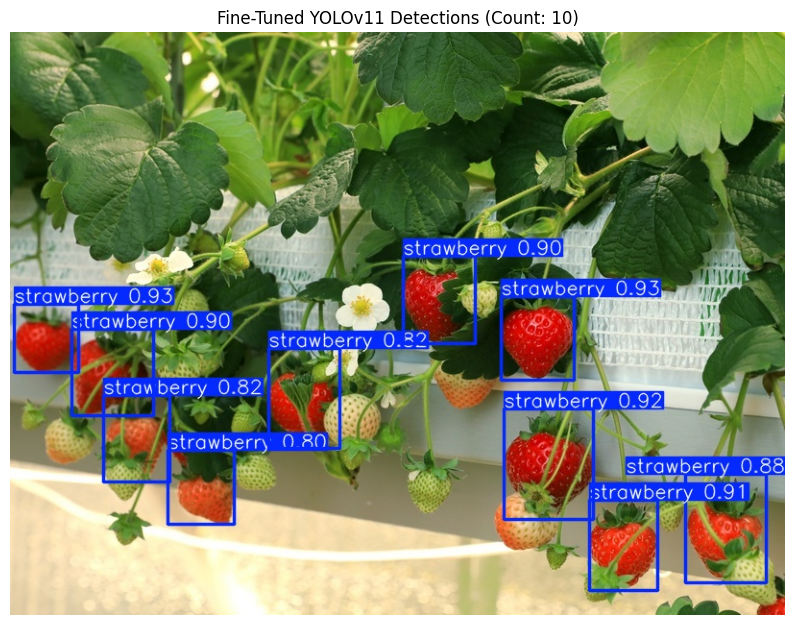

In [9]:
# Path to our best trained weights
finetuned_weights = os.path.join('output', 'train', 'weights', 'best.pt')

# Run inference on a single validation image
sample_img = os.path.join(YOLO_DATASET_DIR, 'images', 'val', '13.png')
print(f"Running fine-tuned YOLOv11 inference on sample image {sample_img}...")
finetuned_count = run_inference(finetuned_weights, sample_img, FINETUNED_OUT_DIR, conf=0.70)
print(f"Fine-tuned model detected {finetuned_count} strawberries in the sample image.")

# Display the prediction output image (ultralytics saves as .jpg by default)
pred_filename = os.path.basename(sample_img).replace('.png', '.jpg')
pred_path = os.path.join(FINETUNED_OUT_DIR, 'predictions', pred_filename)
if os.path.exists(pred_path):
    pred_img = cv2.imread(pred_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Fine-Tuned YOLOv11 Detections (Count: {finetuned_count})")
    plt.axis('off')
    plt.show()
else:
    print(f"Could not find result file at {pred_path}")

## Conclusion

By comparing the outputs, we can clearly see the progression:
- **OpenCV Baseline**: Fast and simple, but brittle and inaccurate.
- **Pre-trained YOLO**: Failed to detect the strawberries correctly as it wasn't trained for them.
- **Fine-tuned YOLO**: Accurately detects and localizes the strawberries after being trained on our custom dataset.

This demonstrates the power of transfer learning and fine-tuning for custom object detection tasks.


=== Testing All Detection Steps (Single Image) ===


2025-07-02 00:17:01,059 - INFO - Baseline detection complete - 0 items found.


Baseline (Template Matching) detected: 0 strawberries.


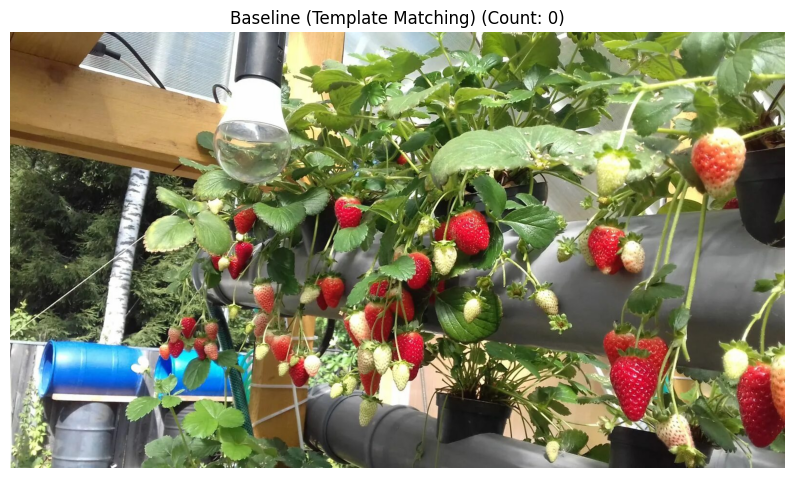


image 1/1 c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset\images\val\14.png: 480x640 1 bench, 1 surfboard, 1 knife, 2 broccolis, 1 chair, 94.5ms
Speed: 2.8ms preprocess, 94.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)
Results saved to c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\output\pretrained_preds\predictions


2025-07-02 00:17:01,695 - INFO - Inference complete. Found 0 strawberry detections.


Pre-trained YOLOv11 detected: 0 strawberries.


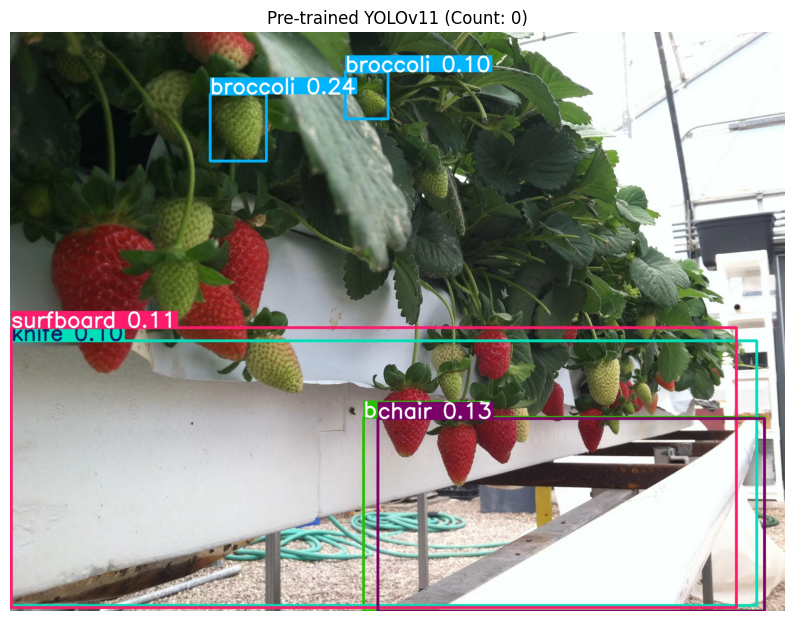


image 1/1 c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\strawberry_dataset\images\val\14.png: 480x640 9 strawberrys, 16.3ms
Speed: 5.3ms preprocess, 16.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\output\finetuned_preds\predictions


2025-07-02 00:17:02,396 - INFO - Inference complete. Found 9 strawberry detections.


Fine-tuned YOLOv11 detected: 9 strawberries.


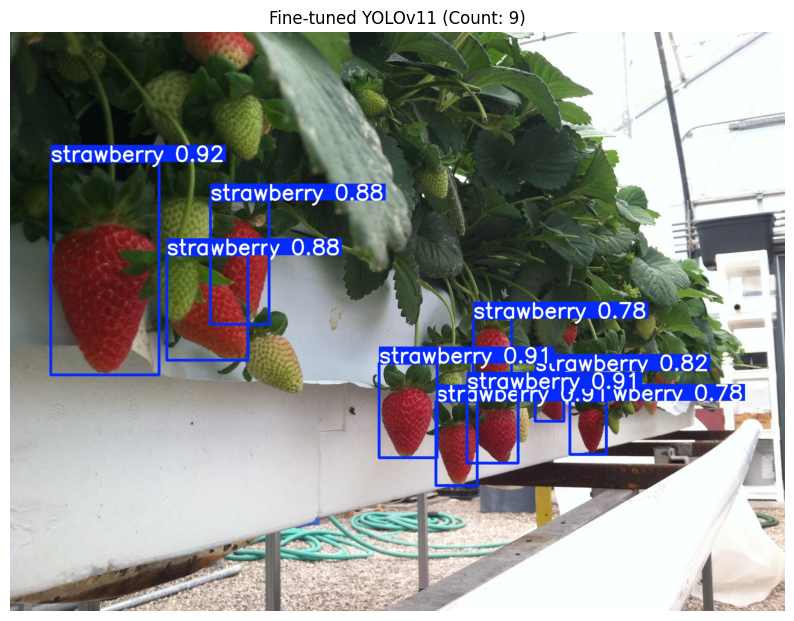

9

In [10]:
def detect_and_show(model, image_path, out_dir, conf, method_name, run_func):
    """
    Runs detection, displays the result image, and prints the count.
    - model: model weights or template path (as needed by run_func)
    - image_path: path to the image to process
    - out_dir: output directory for predictions
    - conf: confidence threshold (if applicable)
    - method_name: string for plot title
    - run_func: function to run detection (should return count)
    """
    # Always call with 4 arguments for consistency
    count = run_func(model, image_path, out_dir, conf)
    print(f"{method_name} detected: {count} strawberries.")

    # Determine output image path
    if method_name.lower().startswith("baseline"):
        result_path = out_dir  # Baseline writes directly to out image
    else:
        # YOLO saves as .jpg in predictions subfolder
        pred_filename = os.path.basename(image_path).replace('.png', '.jpg')
        result_path = os.path.join(out_dir, 'predictions', pred_filename)
    if os.path.exists(result_path):
        img = cv2.imread(result_path)
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{method_name} (Count: {count})")
        plt.axis('off')
        plt.show()
    else:
        print(f"Could not find result file at {result_path}")
    return count

def show_image_with_count(image_path, count, title="Image"):
    """Display an image with the count in the title."""
    img = cv2.imread(image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{title} (Count: {count})")
    plt.axis('off')
    plt.show()

# Example usage for all three methods:
sample_val_img = os.path.join(YOLO_DATASET_DIR, 'images', 'val', '14.png')
print("\n=== Testing All Detection Steps (Single Image) ===")

# Baseline
detect_and_show(
    model=TEMPLATE_PATH,
    image_path=os.path.join(IMAGES_DIR, '1.png'),
    out_dir=BASELINE_OUT,
    conf=None,
    method_name="Baseline (Template Matching)",
    run_func=lambda tpl, img, out, conf: run_baseline(img, tpl, out)
)

# Pre-trained YOLOv11
detect_and_show(
    model=PRETRAINED_MODEL,
    image_path=sample_val_img,
    out_dir=PRETRAINED_OUT_DIR,
    conf=0.1,
    method_name="Pre-trained YOLOv11",
    run_func=run_inference
)

# Fine-tuned YOLOv11
detect_and_show(
    model=finetuned_weights,
    image_path=sample_val_img,
    out_dir=FINETUNED_OUT_DIR,
    conf=0.70,
    method_name="Fine-tuned YOLOv11",
    run_func=run_inference
)